# Automated DFT

This lesson focuses on key concepts necessary to run automated Density Functional Theory (DFT) workflows using our atomate code. We begin by focusing on using pymatgen to build inputs and parsing outputs of DFT calculations. Then we will go through a demonstration of using atomate to run DFT calculations.


## Core Concepts
- **Writing Input Files** - There is an enitre module in pymatgen devoted to reading and writing the input and output files of other codes to assist in calculation automation.
- **Parsing Output Files** - Similar to handling input files, pymatgen also supports parsing output files. This machinery is also used by automate to parse entire output directories.
- **Database Automation** - Atomate combines everything needed to automate running DFT calculations and storing them in a database.


For this lesson to work, we'll need to setup pymatgen with some files, pseudopotential that describe the charge density around each element, that typically are only available to registered VASP users. We've made some fake files with the correct structure so that pymatgen will still function.

In [49]:
import mp_workshop

## Lesson 1: Writing Input Files

For the first lesson we'll focus on using pymatgen to simplfy interfacing with DFT codes. Pymatgen has a IO (input/output) module which has methods to parse and write files that are compatible with a number of external codes. These external codes are written in coding languages other than python (e.g. Fortran, C, C++, etc.) but pymatgen's IO module allows us to interface with them all through python. These external codes include:

- AbInit
- EXCITING
- FEFF
- LAMMPS
- Lobster
- QChem
- VASP
- ATAT
- Gaussian
- NWCHem
- ShengBTE
- Wannier90
- Zeo++

For today's lesson, we will focus on one of these codes, VASP (Vienna Ab initio Simulation Package), which is a DFT code for atomic scale materials modeling. VASP is the DFT code used by the Materials Project for inorganic crystals. We will also use a second DFT code, Q-Chem, in the exercises which is used by the Materials Project for molecules.

### POSCAR Demonstration
Let's begin by obtaining a silicon structure to use in today's lesson. We will import this structure from a CIF (Crystallographic Information File) file which is not compatible with many DFT codes.

In [2]:
from pymatgen.core import Structure
struct = Structure.from_file(filename="./example_files/Si.CIF")
print(struct)

Full Formula (Si8)
Reduced Formula: Si
abc   :   5.523145   5.468728   5.468728
angles:  90.000000  90.000000  90.000000
Sites (8)
  #  SP       a     b     c
---  ----  ----  ----  ----
  0  Si    0.25  0.25  0.25
  1  Si    0.5   0.5   0
  2  Si    0.25  0.75  0.75
  3  Si    0.5   0     0.5
  4  Si    0.75  0.25  0.75
  5  Si    0     0.5   0.5
  6  Si    0.75  0.75  0.25
  7  Si    0     0     0


VASP has 4 types of input files that must be provided by the user to run a calculation:
* **INCAR:** specifies modeling parameters (how to run the calculation)
* **POSCAR:** provides atomic structure
* **KPOINTS:** outlines points for sampling space in the simulation cell
* **POTCAR:** describes how to simulate electrons via pseudopotentials

Pymatgen has python objects for representing each type of input file. For this lesson, we will first focus on the POSCAR to demonstrate the capabilties of these python objects.

In [3]:
from pymatgen.io.vasp.inputs import Poscar

Let's obtain a Poscar python object using the silicon structure object from before. 

In [4]:
poscar = Poscar(structure=struct,comment="silicon")
print(poscar)

silicon
1.0
5.523145 0.000000 0.000000
-0.000000 5.468728 0.000000
0.000000 0.000000 5.468728
Si
8
direct
0.250000 0.250000 0.250000 Si
0.500000 0.500000 0.000000 Si
0.250000 0.750000 0.750000 Si
0.500000 0.000000 0.500000 Si
0.750000 0.250000 0.750000 Si
0.000000 0.500000 0.500000 Si
0.750000 0.750000 0.250000 Si
0.000000 0.000000 0.000000 Si



Since we can construct POSCARs from any structure object, we can make modifications to structure objects (make supercells, remove atoms to form defects, etc.) and construct complex structures (e.g. heterostructures, adsorbates on surfaces, etc.) all using pymatgen before turning the structure into a POSCAR file. 

In this Poscar object there is a full pymatgen structure that we can manipulate pythonically. To demonstrate, let's introduce a defect by removing the first site. To check our work, we look at how the Poscar has changed and print out the number of sites in our original struct (8) and the Poscar structure (7).

In [5]:
poscar.structure.remove_sites([0])

In [6]:
print(poscar)

silicon
1.0
5.523145 0.000000 0.000000
-0.000000 5.468728 0.000000
0.000000 0.000000 5.468728
Si
7
direct
0.500000 0.500000 0.000000 Si
0.250000 0.750000 0.750000 Si
0.500000 0.000000 0.500000 Si
0.750000 0.250000 0.750000 Si
0.000000 0.500000 0.500000 Si
0.750000 0.750000 0.250000 Si
0.000000 0.000000 0.000000 Si



In [7]:
print(struct.num_sites,poscar.structure.num_sites)

8 7


When your structure is ready, in order to obtain our POSCAR file for running VASP, the Poscar object has a method for writing it out as a file.

In [8]:
poscar.write_file(filename="POSCAR")

Another useful method is getting a Poscar object from a POSCAR file that has already been written. Note you are able to import a compressed file without unzipping it.

In [9]:
poscar_from_file = Poscar.from_file(filename="./example_files/POSCAR.gz")
print(poscar_from_file)

Al16 Cr10
1.0
7.417988 0.000000 -2.655322
-3.770804 6.388081 -2.655321
0.000000 0.000000 7.878914
Al Cr
16 10
direct
0.696455 0.696455 0.696455 Al
0.646563 0.002044 0.646563 Al
0.646563 0.646563 0.002044 Al
0.002044 0.646563 0.646563 Al
0.336523 0.558569 0.336523 Al
0.336523 0.336523 0.558569 Al
0.558569 0.336523 0.336523 Al
0.734771 0.383622 0.734771 Al
0.734771 0.734771 0.383622 Al
0.383622 0.734771 0.734771 Al
0.280797 0.666745 0.038053 Al
0.038053 0.280797 0.666745 Al
0.666745 0.038053 0.280797 Al
0.666745 0.280797 0.038053 Al
0.038053 0.666745 0.280797 Al
0.280797 0.038053 0.666745 Al
0.151124 0.151124 0.151124 Cr
0.015343 0.797266 0.015343 Cr
0.015343 0.015343 0.797266 Cr
0.797266 0.015343 0.015343 Cr
0.987828 0.333690 0.987828 Cr
0.987828 0.987828 0.333690 Cr
0.333690 0.987828 0.987828 Cr
0.365023 0.015932 0.365023 Cr
0.365023 0.365023 0.015932 Cr
0.015932 0.365023 0.365023 Cr



All the python objects for VASP inputs (INCAR, POSCAR, KPOINTS, POTCAR) have similar methods for initiating the object and writing out files. See the pymatgen documentation for more details: https://pymatgen.org/_modules/pymatgen/io/vasp/inputs.html

### Input Sets

It can still take quite some effort to explicitly generate each input file needed for calculation. To further automatation, pymatgen builds upon these pieces to generate `InputSets`. InputSets are objects that provide default parameters to perform a specific kind of calcualtion. Pymatgen has several InputSets including ones with the default paramters used for MP calculations. But it is also possible to define your own InputSet that lets you build new calculations using the parameters you want.

Let's continue with our silicon structure from before. To generate the remaining input files needed for a VASP calculation, let's use an InputSet object. To perform a structure relaxation, we can import the parameters used in the Materials Project from `MPRelaxSet`.

In [10]:
from pymatgen.io.vasp.sets import MPRelaxSet

Note all we need to initiate the MPRelaxSet InputSet is a structure object. All the information we need to generate the four VASP input files can be determined from the provided structure.

In [11]:
relax_set = MPRelaxSet(structure=struct)

We can access the pythonic object for each of the VASP Input files (INCAR, POSCAR, KPOINTS, POTCAR) from our InputSet object.

In [12]:
relax_set.incar

{'ALGO': 'Fast',
 'EDIFF': 0.0004,
 'ENCUT': 520,
 'IBRION': 2,
 'ISIF': 3,
 'ISMEAR': -5,
 'ISPIN': 2,
 'LASPH': True,
 'LORBIT': 11,
 'LREAL': 'Auto',
 'LWAVE': False,
 'NELM': 100,
 'NSW': 99,
 'PREC': 'Accurate',
 'SIGMA': 0.05,
 'MAGMOM': [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6]}

In [13]:
relax_set.poscar

Si8
1.0
5.523145 0.000000 0.000000
-0.000000 5.468728 0.000000
0.000000 0.000000 5.468728
Si
8
direct
0.250000 0.250000 0.250000 Si
0.500000 0.500000 0.000000 Si
0.250000 0.750000 0.750000 Si
0.500000 0.000000 0.500000 Si
0.750000 0.250000 0.750000 Si
0.000000 0.500000 0.500000 Si
0.750000 0.750000 0.250000 Si
0.000000 0.000000 0.000000 Si

In [14]:
relax_set.kpoints

pymatgen with grid density = 769 / number of atoms
0
Monkhorst
4 4 4

In [15]:
relax_set.potcar.as_dict()

{'functional': 'PBE',
 'symbols': ['Si'],
 '@module': 'pymatgen.io.vasp.inputs',
 '@class': 'Potcar'}

InputSet has a `.write_input()` method which will write out all the VASP input files we need to run a structure optimization for our silicon structure. Let's specify writing our input files to a directory as if we were going to launch VASP from that directory.

Note we will also set the `potcar_spec=True` flag to avoid writing an actual POTCAR file (which is composed from POTCAR files that can only be distrubuted under a VASP license). By default, POTCARs will be written based on POTCARs specifed by the environment variable `PMG_VASP_PSP_DIR`.

In [16]:
relax_set.write_input(output_dir="./Si_MPRelaxSet",potcar_spec=True)

## Lesson 2: Parsing Output Files

After VASP has been run, you'll need to parse the VASP outputs to get the data you want. VASP makes a number of output files: 

- WAVECAR
- CHGCAR
- OUTCAR
- vasprun.xml
- PROCAR
- And more ...

Please refer to [VASP's documentation](https://www.vasp.at/wiki/index.php/The_VASP_Manual) for descriptions of what these all are. 

### Vasprun Demonstration

For this portion of the lesson, we'll focus on vasprun.xml.gz in the example_VASP_Al16Cr10 directory. Similar to how pymatgen has objects corresponding to VASP input files, pymatgen has a `Vasprun` python object for parsing the outputs contained in vasprun.xml files.

In [ ]:
from pymatgen.io.vasp.outputs import Vasprun
vrun = Vasprun(filename="./example_VASP_Al16Cr10/vasprun.xml.gz")

Since Vasprun objects have most of the information that VASP can provide, this one object is often enough to parse a full VASP calculation. Use vrun.+Tab to check out the properties from the Vasprun object. 

For example, we can check if the calculation is converged as well as the the final structure and energy after the structure optimization was finished.

In [18]:
vrun.converged

True

In [19]:
vrun.final_structure

Structure Summary
Lattice
    abc : 7.858339351222918 7.858486224302677 7.857828722726137
 angles : 109.68307448574032 109.6862509307799 109.68598356491901
 volume : 370.5637945511443
      A : 7.41150067 -0.06594902 -2.61128434
      B : -3.66951308 6.43992452 -2.61110162
      C : -0.0388319 -0.06592473 7.85745622
PeriodicSite: Al (2.5789, 4.3928, 1.8349) [0.6964, 0.6964, 0.6964]
PeriodicSite: Al (4.7570, -0.0715, 3.3849) [0.6463, 0.0021, 0.6463]
PeriodicSite: Al (2.4184, 4.1194, -3.3584) [0.6463, 0.6463, 0.0021]
PeriodicSite: Al (-2.3810, 4.1196, 3.3853) [0.0021, 0.6463, 0.6463]
PeriodicSite: Al (0.4331, 3.5525, 0.3080) [0.3367, 0.5585, 0.3367]
PeriodicSite: Al (1.2385, 2.1091, 2.6301) [0.3367, 0.3367, 0.5585]
PeriodicSite: Al (2.8908, 2.1093, 0.3082) [0.5585, 0.3367, 0.3367]
PeriodicSite: Al (4.0091, 2.3707, 2.8527) [0.7345, 0.3832, 0.7345]
PeriodicSite: Al (2.7336, 4.6565, -0.8251) [0.7345, 0.7345, 0.3832]
PeriodicSite: Al (0.1161, 4.6564, 2.8529) [0.3832, 0.7345, 0.7345]
Periodic

In [20]:
vrun.final_energy

-157.80974238

Another useful set of data is stored under `.ionic_steps` because this contains information on how the calculation progressed during each ionic step in the structure optimization.

We can check how many ionic steps were taken and what properties are stored for each ionic step. 

In [21]:
len(vrun.ionic_steps)

4

In [22]:
vrun.ionic_steps[0].keys()

dict_keys(['e_fr_energy', 'e_wo_entrp', 'e_0_energy', 'forces', 'stress', 'electronic_steps', 'structure'])

By looping through we can see the energy at the end of each ionic step and how many electronic steps were required during each ionic step.

In [23]:
for i in vrun.ionic_steps:
    print(i["e_fr_energy"] ,len(i["electronic_steps"]))

-157.49049217 18
-157.58170253 13
-157.69641768 27
-157.80974238 10


### Parsing Directories with Atomate Drones

To take parsing outputs from external codes one step further, we will introduce the concept of `drones` from the python code package, `atomate`. Pymatgen provides methods for parsing individual output files. Atomate drones combine these capabilities to parse entire output calculation directories and has an `.assimilate()` methode to produce a dictionary summarizing the results. This dictionary representation is helpful because it can be stored in a database as done with the Materials Project.

In [24]:
from atomate.vasp.drones import VaspDrone

In [25]:
drone = VaspDrone()

In [26]:
task_doc = drone.assimilate(path="./example_VASP_Al16Cr10")

2021-07-29 12:34:09,566 INFO atomate.vasp.drones Getting task doc for base dir :./example_VASP_Al16Cr10
2021-07-29 12:34:11,475 INFO atomate.vasp.drones Post-processing dir:./example_VASP_Al16Cr10
2021-07-29 12:34:11,476 WARNING atomate.vasp.drones Transformations file does not exist.
2021-07-29 12:34:11,483 INFO atomate.vasp.drones Post-processed /Users/shyamd/Dropbox/Codes/workshop/workshop/lessons/05_automated_dft/example_VASP_Al16Cr10


In [27]:
print(task_doc.keys())

dict_keys(['schema', 'dir_name', 'calcs_reversed', 'run_stats', 'chemsys', 'formula_anonymous', 'formula_reduced_abc', 'completed_at', 'nsites', 'composition_unit_cell', 'composition_reduced', 'formula_pretty', 'elements', 'nelements', 'input', 'output', 'state', 'analysis', 'last_updated', 'transformations'])


## Lesson 3: Database Automation

The final section of this lesson focuses on automating DFT using our `atomate` code. `atomate` is a set of recipes for computing properties for both molecules and structures. The workflows in `atomate` run on `fireworks`, our workflow management software. `fireworks` stores workflow information and calculation summaries in MongoDB. Using this infrastructure MP routinely manages 10,000 simultaneous calculations on supercomputers such as Cori at NERSC. 

### Getting Workflows

Let's begin by importing a basic silicon structure

In [28]:
from pymatgen.core import Structure
si = Structure.from_file("./example_files/Si.CIF")
print(si)

Full Formula (Si8)
Reduced Formula: Si
abc   :   5.523145   5.468728   5.468728
angles:  90.000000  90.000000  90.000000
Sites (8)
  #  SP       a     b     c
---  ----  ----  ----  ----
  0  Si    0.25  0.25  0.25
  1  Si    0.5   0.5   0
  2  Si    0.25  0.75  0.75
  3  Si    0.5   0     0.5
  4  Si    0.75  0.25  0.75
  5  Si    0     0.5   0.5
  6  Si    0.75  0.75  0.25
  7  Si    0     0     0


In the past two lessons we've gone over some of the machinery used in this automation. Atomate workflows (with the support of fireworks) compiles everything needed to:
* Store workflow inputs from the user
* Create new calculation directories and write input files
* Parse output directories and store results in a MongoDB database

We can import `workflows` from atomate which are essentially the recipes that outline the steps for how to automate calculations from start to finish. There are many pre-built workflows in automate for common types of calculations. The best way to explore all available workflows is by checking the atomate source code linked below.
* VASP Workflows: https://github.com/hackingmaterials/atomate/tree/main/atomate/vasp/workflows/base
* Q-Chem Workflows: https://github.com/hackingmaterials/atomate/tree/main/atomate/qchem/workflows/base

For this lesson, we will focus on two types of workflows for VASP.
* Structure Optimization Workflow (simpler)
* Bandstructure Workflow (more complex)

Let's get started by importing these workflows and then creating workflow objects from our silicon structure.

In [29]:
from atomate.vasp.workflows.presets.core import wf_structure_optimization, wf_bandstructure

In [30]:
so_wf = wf_structure_optimization(structure=si)
print(so_wf)

Workflow object: (fw_ids: odict_keys([-1]) , name: Si)


In [31]:
bs_wf = wf_bandstructure(structure=si)
print(bs_wf)

Workflow object: (fw_ids: odict_keys([-2, -3, -4, -5]) , name: Si)


The structure optimization workflow is simpler and we can see that it only contains one firework. The bandstructure workflow has four fireworks so we can assume it is more complex. Let's see a graphical representation of each of these workflows.

In [32]:
from mp_workshop.atomate import wf_to_graph

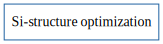

In [33]:
wf_to_graph(so_wf)

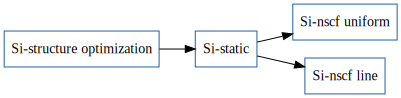

In [34]:
wf_to_graph(bs_wf)

The exact steps in each firework can vary but for these cases, each firework roughly represents one VASP calculation which consists of the following steps:

    1. Write VASP input files
    2. Run VASP
    3. Parse VASP output files

In the more complex bandstructure workflow, we can see the fireworks are connected. That means the outputs from one firework are passed to the next firework so the VASP calculation can start from the relaxed structure of the previous calculation.

Before we move forward with running our workflows, we will make one modification called `use_fake_vasp_workshop`. This will change the fireworks in the workflows so they will not actually run VASP (which requires greater computer resources and a VASP license), but instead will simulate running VASP by copying over pre-existing VASP output files.

In [35]:
from mp_workshop.atomate import use_fake_vasp_workshop

In [36]:
so_wf = use_fake_vasp_workshop(so_wf)
bs_wf = use_fake_vasp_workshop(bs_wf)

### Launching Workflows from Your LaunchPad

Now we will introduce the `LaunchPad` from fireworks which is a python object that let's us interface with MongoDB and manage our queue of calculations. The LaunchPad allows you to submit and query workflows from anywhere you have database access. We need to get ourselves a LaunchPad object and set it up so we can submit our workflows.

In [37]:
from fireworks import LaunchPad

In [38]:
lp = LaunchPad.auto_load()

In [39]:
lp.reset(password=None,require_password=False)

2021-07-29 12:34:11,822 INFO Performing db tune-up
2021-07-29 12:34:12,230 INFO LaunchPad was RESET.


Note `lp.reset()` should only be executed one time when you are first initializing your database set-up. If you reset your LaunchPad at a later time, you will erase the record of past calcuations you have run.

Adding our workflows to our Launchpad will encode and store our workflow objects into MongoDB so they can be accessed later. Let's start by adding one workflow, the simpler structure optimization workflow.

In [40]:
lp.add_wf(so_wf)

2021-07-29 12:34:12,244 INFO Added a workflow. id_map: {-1: 1}


{-1: 1}

Now that a workflow is in our LaunchPad, we can check on its status using `.get_wf_summary_dict()`

In [41]:
lp.get_wf_summary_dict(fw_id=1)

{'state': 'READY',
 'name': 'Si',
 'created_on': datetime.datetime(2021, 7, 29, 19, 34, 11, 524000),
 'updated_on': datetime.datetime(2021, 7, 29, 19, 34, 11, 524000),
 'states': OrderedDict([('Si-structure optimization--1', 'READY')]),
 'launch_dirs': OrderedDict([('Si-structure optimization--1', [])])}

Now that we a workflow in our LaunchPad, we are ready to run it. Normally we run fireworks through the command-line interface on supercomputers because external codes, such as VASP, require more compute resources. However, for today's demonstration, we will run our workflows locally in this notebook to illustrate how it works.

Fireworks has a command called `rlaunch` for "launching" or running a firework in a workflow from our LaunchPad. Let's see how to use it and use "rapidfire" mode.

In [42]:
!rlaunch --help

FW Echo Test: MP Workshop
usage: rlaunch [-h] [-l LAUNCHPAD_FILE] [-w FWORKER_FILE] [-c CONFIG_DIR]
               [--loglvl LOGLVL] [-s]
               {singleshot,rapidfire,multi} ...

This program launches one or more Rockets. A Rocket retrieves a job from the
central database and runs it. The "single-shot" option launches a single
Rocket, whereas the "rapidfire" option loops until all FireWorks are
completed.

positional arguments:
  {singleshot,rapidfire,multi}
                        command
    singleshot          launch a single Rocket
    rapidfire           launch multiple Rockets (loop until all FireWorks
                        complete)
    multi               launches multiple Rockets simultaneously

optional arguments:
  -h, --help            show this help message and exit
  -l LAUNCHPAD_FILE, --launchpad_file LAUNCHPAD_FILE
                        path to launchpad file
  -w FWORKER_FILE, --fworker_file FWORKER_FILE
                        path to fworker file
  -c CON

In [43]:
!rlaunch rapidfire

FW Echo Test: MP Workshop
2021-07-29 12:34:13,903 INFO Hostname/IP lookup (this will take a few seconds)
2021-07-29 12:34:17,462 INFO Created new dir /Users/shyamd/Dropbox/Codes/workshop/workshop/lessons/05_automated_dft/launcher_2021-07-29-19-34-17-462079
2021-07-29 12:34:17,462 INFO Launching Rocket
2021-07-29 12:34:17,486 INFO RUNNING fw_id: 1 in directory: /Users/shyamd/Dropbox/Codes/workshop/workshop/lessons/05_automated_dft/launcher_2021-07-29-19-34-17-462079
2021-07-29 12:34:17,510 INFO Task started: FileWriteTask.
2021-07-29 12:34:17,511 INFO Task completed: FileWriteTask 
2021-07-29 12:34:17,512 INFO Task started: {{atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet}}.
2021-07-29 12:34:17,552 INFO Task completed: {{atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet}} 
2021-07-29 12:34:17,554 INFO Task started: {{atomate.vasp.firetasks.run_calc.RunVaspFake}}.
2021-07-29 12:34:17,555 INFO atomate.vasp.firetasks.run_calc RunVaspFake: verified inputs successfully
2021-07-2

Let's check on our workflow in our LaunchPad to see how it has changed after launching one firework.

In [44]:
lp.get_wf_summary_dict(fw_id=1)

{'state': 'COMPLETED',
 'name': 'Si',
 'created_on': datetime.datetime(2021, 7, 29, 19, 34, 11, 524000),
 'updated_on': datetime.datetime(2021, 7, 29, 19, 34, 18, 378000),
 'states': OrderedDict([('Si-structure optimization--1', 'COMPLETED')]),
 'launch_dirs': OrderedDict([('Si-structure optimization--1',
               ['/Users/shyamd/Dropbox/Codes/workshop/workshop/lessons/05_automated_dft/launcher_2021-07-29-19-34-17-462079'])])}

Great! We can see the state of the one firework in our workflow has changed to COMPLETED and now the workflow is done.

Now let's try running the more complicated bandstructure workflow which has four fireworks. First let's add the workflow to our LaunchPad and look at its summary dictionary.

In [45]:
lp.add_wf(bs_wf)

2021-07-29 12:34:19,493 INFO Added a workflow. id_map: {-5: 2, -4: 3, -3: 4, -2: 5}


{-5: 2, -4: 3, -3: 4, -2: 5}

In [46]:
lp.get_wf_summary_dict(fw_id=2)

{'state': 'READY',
 'name': 'Si',
 'created_on': datetime.datetime(2021, 7, 29, 19, 34, 11, 536000),
 'updated_on': datetime.datetime(2021, 7, 29, 19, 34, 11, 536000),
 'states': OrderedDict([('Si-nscf line--2', 'WAITING'),
              ('Si-nscf uniform--3', 'WAITING'),
              ('Si-static--4', 'WAITING'),
              ('Si-structure optimization--5', 'READY')]),
 'launch_dirs': OrderedDict([('Si-nscf line--2', []),
              ('Si-nscf uniform--3', []),
              ('Si-static--4', []),
              ('Si-structure optimization--5', [])])}

Now let's move forward with running the workflow. Note that if the `--nlaunches` flag is not used, `rlaunch rapidfire` will continue to launch more fireworks from the LaunchPad until no "READY" fireworks remain. This is convenient for our case because we have 4 fireworks in our workflow that need to run.

In [47]:
!rlaunch rapidfire 

FW Echo Test: MP Workshop
2021-07-29 12:34:20,268 INFO Hostname/IP lookup (this will take a few seconds)
2021-07-29 12:34:23,021 INFO Created new dir /Users/shyamd/Dropbox/Codes/workshop/workshop/lessons/05_automated_dft/launcher_2021-07-29-19-34-23-021397
2021-07-29 12:34:23,021 INFO Launching Rocket
2021-07-29 12:34:23,042 INFO RUNNING fw_id: 5 in directory: /Users/shyamd/Dropbox/Codes/workshop/workshop/lessons/05_automated_dft/launcher_2021-07-29-19-34-23-021397
2021-07-29 12:34:23,054 INFO Task started: FileWriteTask.
2021-07-29 12:34:23,074 INFO Task completed: FileWriteTask 
2021-07-29 12:34:23,076 INFO Task started: {{atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet}}.
2021-07-29 12:34:23,128 INFO Task completed: {{atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet}} 
2021-07-29 12:34:23,130 INFO Task started: {{atomate.vasp.firetasks.run_calc.RunVaspFake}}.
2021-07-29 12:34:23,131 INFO atomate.vasp.firetasks.run_calc RunVaspFake: verified inputs successfully
2021-07-2

Once `rlaunch rapidfire` has finished running, now we can check to see if this workflow completed successfully.

In [48]:
lp.get_wf_summary_dict(fw_id=2)

{'state': 'COMPLETED',
 'name': 'Si',
 'created_on': datetime.datetime(2021, 7, 29, 19, 34, 11, 536000),
 'updated_on': datetime.datetime(2021, 7, 29, 19, 34, 28, 580000),
 'states': OrderedDict([('Si-nscf line--2', 'COMPLETED'),
              ('Si-nscf uniform--3', 'COMPLETED'),
              ('Si-static--4', 'COMPLETED'),
              ('Si-structure optimization--5', 'COMPLETED')]),
 'launch_dirs': OrderedDict([('Si-nscf line--2',
               ['/Users/shyamd/Dropbox/Codes/workshop/workshop/lessons/05_automated_dft/launcher_2021-07-29-19-34-25-534425']),
              ('Si-nscf uniform--3',
               ['/Users/shyamd/Dropbox/Codes/workshop/workshop/lessons/05_automated_dft/launcher_2021-07-29-19-34-27-263055']),
              ('Si-static--4',
               ['/Users/shyamd/Dropbox/Codes/workshop/workshop/lessons/05_automated_dft/launcher_2021-07-29-19-34-24-027986']),
              ('Si-structure optimization--5',
               ['/Users/shyamd/Dropbox/Codes/workshop/workshop/

Fireworks also has a command called `qlaunch` to automatically submit jobs to the supercomputer to run. Upon the job starting on the supercomputer, rlaunch from fireworks will be called thus running fireworks with supercomputer resources. qlaunch is the primary command used by users in the command-line interface on supercomputers.